In [1]:
import cv2
import collections
import time 
from tqdm import tqdm
from PIL import Image
from functools import partial
train_on_gpu = True
import copy
import torch
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import nibabel as nib
import subprocess
import matplotlib.pyplot as plt
import cv2
import pydicom
from PIL import Image
import time
import sys
from IPython.display import clear_output
import os

import re
def export_num(string):
    find_num = re.compile('[0-9.]+')
    number = find_num.findall(string[-10:-4])
    return int(number[0])

seed = 1015
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

(512, 948)


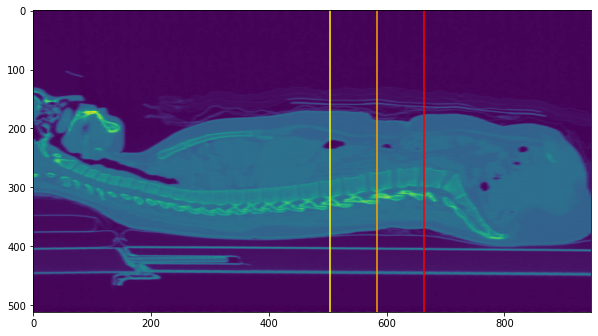

In [4]:
PATH = "../../../../../cpt_data/ct_new/"
images_paths = []
i = 0
for person_id in os.listdir(PATH + f"1.원본/"):
    i +=1
    original_list = os.listdir(PATH + f"1.원본/{person_id}")
    original_path = pd.DataFrame(
                                {"1.원본" : original_list},
                                index = list(map(export_num, original_list))
                               ).sort_index()
    original_max = original_path.index.max()
    
    # 근욱을 기준으로 생성
    musle_list = os.listdir(PATH + f"2.근육/tif/{person_id}")
    file_names = pd.DataFrame({"2.근육" : musle_list},
                                index = list(map(export_num, musle_list))
                               ).sort_index()
    
    file_names["2.근육"] = PATH + f"2.근육/tif/{person_id}/" +\
                            file_names["2.근육"]
    musle_min = file_names.index.min()
    musle_max = file_names.index.max()
    
    original_path.index = original_max - original_path.index
    #file_names["1.원본"] = original_path.loc[musle_max:musle_min-1]
    
    original_3d = np.zeros((512,512, len(original_path)))
    for z, original_2d_path in enumerate(original_path['1.원본']):
        original_3d[:,:,z] = np.array(pydicom.dcmread(PATH + f"1.원본/{person_id}/{original_2d_path}").pixel_array)
        
    plt.figure(figsize = (10,10))
    mul = 4
    resized = cv2.resize(original_3d[:,256,:], (original_3d.shape[2]*mul, 512))
    print(resized.shape)
    z_size = 512
    max_z = resized.shape[1]
    min_z = resized.shape[1] - z_size
    #resized = resized[]
    plt.imshow(resized)
    l3_end = original_max*mul - musle_min*mul
    l3_start = original_max*mul - musle_max*mul
    
    plt.axvline(original_max*mul - musle_min*mul, color = 'red')
    plt.axvline((original_max*mul - (musle_min+musle_max)*mul/2), color = 'orange')
    plt.axvline(original_max*mul - musle_max*mul, color = 'yellow')
    plt.show()
    break

 25%|██▌       | 15/60 [00:38<01:51,  2.49s/it]

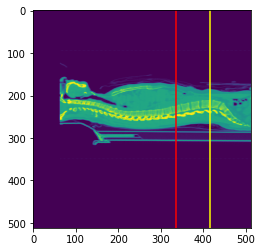

 33%|███▎      | 20/60 [00:50<01:35,  2.39s/it]

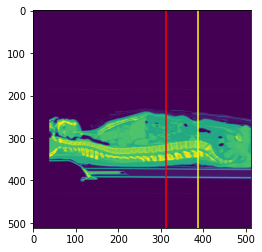

 55%|█████▌    | 33/60 [01:24<01:17,  2.88s/it]

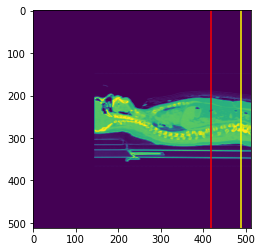

 57%|█████▋    | 34/60 [01:27<01:18,  3.01s/it]

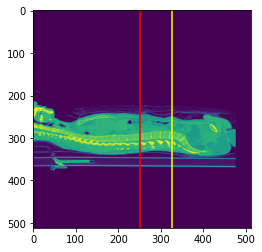

 65%|██████▌   | 39/60 [01:40<00:53,  2.53s/it]

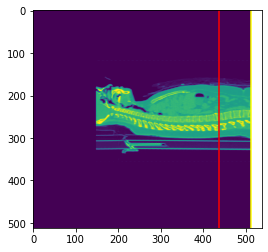

 70%|███████   | 42/60 [01:48<00:44,  2.46s/it]

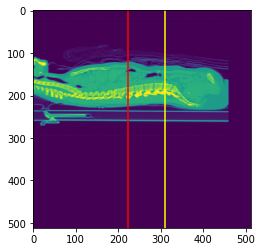

 72%|███████▏  | 43/60 [01:50<00:40,  2.41s/it]

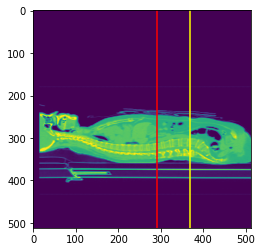

 73%|███████▎  | 44/60 [01:52<00:38,  2.38s/it]

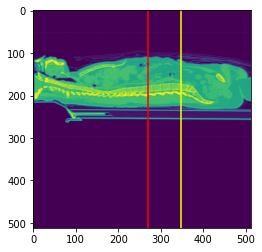

 80%|████████  | 48/60 [02:03<00:31,  2.66s/it]

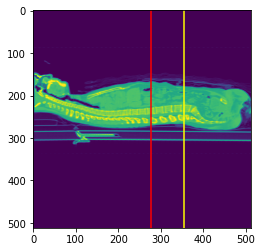

 83%|████████▎ | 50/60 [02:09<00:27,  2.71s/it]

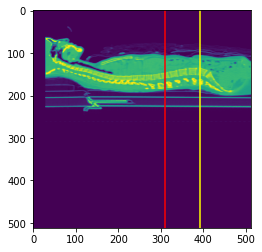

 87%|████████▋ | 52/60 [02:15<00:22,  2.77s/it]

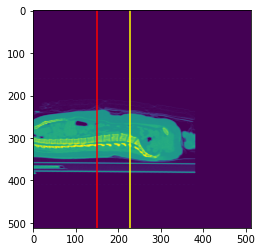

100%|██████████| 60/60 [02:34<00:00,  2.57s/it]


In [82]:
images_paths = []
i = 0
np.random.seed(1015)
l3_location = pd.DataFrame(np.zeros([len(os.listdir(PATH + f"1.원본/")) * 9,3]), columns = ['person_mul_index', 'start_x', 'end_x'])
person_mul_index = []

for item in os.listdir(PATH + f"1.원본/"):
    for Y_loc in range(252, 261):
        person_mul_index += [f'{item}_{Y_loc}']
        
l3_location['person_mul_index'] = person_mul_index
l3_location = l3_location.set_index('person_mul_index')

for person_id in tqdm(os.listdir(PATH + f"1.원본/")):      
    i +=1
    original_list = os.listdir(PATH + f"1.원본/{person_id}")
    original_path = pd.DataFrame(
                                {"1.원본" : original_list},
                                index = list(map(export_num, original_list))
                               ).sort_index()
    original_max = original_path.index.max()
    # 근욱을 기준으로 생성
    musle_list = os.listdir(PATH + f"2.근육/tif/{person_id}")
    file_names = pd.DataFrame({"2.근육" : musle_list},
                                index = list(map(export_num, musle_list))
                               ).sort_index()
    
    file_names["2.근육"] = PATH + f"2.근육/tif/{person_id}/" +\
                            file_names["2.근육"]
    musle_min = file_names.index.min()
    musle_max = file_names.index.max()
    
    original_path.index = original_max - original_path.index
    #file_names["1.원본"] = original_path.loc[musle_max:musle_min-1]
    
    original_3d = np.zeros((512,512, len(original_path)))
    for z, original_2d_path in enumerate(original_path['1.원본']):
        original_2d = np.array(pydicom.dcmread(PATH + f"1.원본/{person_id}/{original_2d_path}").pixel_array)

        original_3d[:,:,z] = original_2d
    
    
    for Y_loc in range(252, 261):
        mul = 4
        sagittal_smaple = original_3d[:,Y_loc,:]
        min_val = np.quantile(sagittal_smaple.reshape(-1), 0.3)
        max_val = np.quantile(sagittal_smaple.reshape(-1), 0.99)
        resized = cv2.resize(sagittal_smaple, (original_3d.shape[2]*mul, 512))
        # 1차 threshold 적용                   
        over_idx  = (resized > max_val)
        under_idx = (resized < min_val)
        
        resized[over_idx]  = max_val
        resized[under_idx] = min_val
        
        resized = (resized - min_val) / (max_val - min_val) * 255    
        resized = resized.astype(np.uint8)#[..., np.newaxis]
        
        z_size = 512
        max_z = resized.shape[1]
        min_z = resized.shape[1] - z_size
        
        l3_end = original_max*mul - musle_min*mul
        l3_start = original_max*mul - musle_max*mul
        
        partial = resized.shape[1] / 512
        y_size = int(512 // partial)
        
        l3_end = original_max*mul - musle_min*mul
        l3_start = original_max*mul - musle_max*mul
        
        l3_end = int(l3_end // partial)
        l3_start = int(l3_start // partial)
        
        resized_512 = cv2.resize(resized, (512, y_size))
        start_y = 256 - resized_512.shape[0]//2
        sample_img = np.zeros([512,512])
        sample_img[start_y : start_y  + resized_512.shape[0]] = resized_512
        
        lr_shift_sample = np.zeros([512, 512])
        if np.random.randint(0,2) == 1:
            # shift right
            new_end = np.random.randint(l3_end, 512)
            lr_shift_sample[:,512 - new_end:] = sample_img[:,:new_end]
            l3_start += 512 - new_end
            l3_end += 512 - new_end
        
        else:
            # shift left
            new_start = np.random.randint(l3_start - 100)
            lr_shift_sample[:,:512 - new_start] = sample_img[:,new_start:]
            l3_start -= new_start
            l3_end -= new_start
        
        
        ud_shift_sample = np.zeros([512, 512])
        upper_bound = 150
        lower_bound = 450
        
        if np.random.randint(0,2) == 1:
            #shift up
            new_upper = np.random.randint(upper_bound)
            ud_shift_sample[:512 - new_upper,:] = lr_shift_sample[new_upper:,:]
            
        else:
            #shift down
            new_lower = np.random.randint(lower_bound, 512)
            ud_shift_sample[512 - new_lower:, :] = lr_shift_sample[:new_lower,:]
            
        person_mul_index = f'{person_id}_{Y_loc}'
        l3_location.loc[person_mul_index, 'start_x'] = l3_start
        l3_location.loc[person_mul_index, 'end_x'] = l3_end 
        
        if np.random.randint(30) == 5:
            plt.imshow(ud_shift_sample)
            plt.axvline(l3_end, c = 'yellow')
            plt.axvline(l3_start, c = 'red')
            plt.show()
        cv2.imwrite(f'../../data/random_shift/img/{person_id}_{Y_loc}.png', ud_shift_sample)


l3_location = l3_location.astype(int)
l3_location.to_csv('../../data/random_shift/random_shift_target.csv')